# TP 1

## 1. Imports and Configuration


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

SAMPLE_RATE = 16000
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 80
HIDDEN_SIZE = 256
NUM_LAYERS = 2
DROPOUT = 0.3
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10


Using device: cuda


## 2. MFCC Extraction (Partie 1 - MLP pur)


In [ ]:
def extract_mfcc(audio_path, sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mfcc=13):
    """
    Extrait les coefficients MFCC d'un fichier audio.
    """

    import soundfile as sf

    waveform_np, sr = sf.read(audio_path)

    waveform = torch.from_numpy(waveform_np).float()
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    else:
        waveform = waveform.transpose(0, 1)
    
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)

    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            'n_fft': n_fft,
            'hop_length': hop_length,
            'n_mels': 128
        }
    )
    
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.squeeze(0).transpose(0, 1)
    
    mean = mfcc.mean(dim=0, keepdim=True)
    std = mfcc.std(dim=0, keepdim=True)
    mfcc = (mfcc - mean) / (std + 1e-8)
    
    return mfcc


## 3. MelSpectrogram Extraction (Partie 2 - CNN)


In [ ]:
def extract_melspectrogram(audio_path, sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    import soundfile as sf

    waveform_np, sr = sf.read(audio_path)
    waveform = torch.from_numpy(waveform_np).float()
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    else:
        waveform = waveform.transpose(0, 1)
    
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    melspectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    melspectrogram = melspectrogram_transform(waveform)
    melspectrogram = melspectrogram.squeeze(0).transpose(0, 1)
    
    melspectrogram = torch.log10(melspectrogram + 1e-8)
    
    mean = melspectrogram.mean(dim=0, keepdim=True)
    std = melspectrogram.std(dim=0, keepdim=True)
    melspectrogram = (melspectrogram - mean) / (std + 1e-8)
    
    return melspectrogram


## 4. Character Encoding


In [21]:
class CharEncoder:
    def __init__(self):
        self.char_to_idx = {'<blank>': 0}
        self.idx_to_char = {0: '<blank>'}
        self.next_idx = 1
    
    def build_vocab(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char_to_idx:
                    self.char_to_idx[char] = self.next_idx
                    self.idx_to_char[self.next_idx] = char
                    self.next_idx += 1
    
    def encode(self, text):
        return [self.char_to_idx.get(char, 0) for char in text]
    
    def decode(self, indices):
        return ''.join([self.idx_to_char.get(idx, '') for idx in indices if idx != 0])
    
    def get_vocab_size(self):
        return len(self.char_to_idx)


## 5. Partie 1 - Architecture MLP pure (sans CNN)


In [ ]:
class SimpleMLPASR(nn.Module):
    """
    Architecture MLP simple pour ASR avec MFCC et CTC.
    Pas de convolutions, juste des couches fully-connected.
    """
    def __init__(
        self,
        input_size,
        vocab_size,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
    ):
        super(SimpleMLPASR, self).__init__()
        
        mlp_layers = []
        
        mlp_layers.append(nn.Linear(input_size, hidden_size))
        mlp_layers.append(nn.ReLU())
        mlp_layers.append(nn.Dropout(dropout))
        
        for _ in range(num_layers - 1):
            mlp_layers.append(nn.Linear(hidden_size, hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))
        
        mlp_layers.append(nn.Linear(hidden_size, vocab_size))
        self.mlp = nn.Sequential(*mlp_layers)
    
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        x = x.contiguous().view(-1, features)
        x = self.mlp(x)
        x = x.view(batch_size, seq_len, -1)
        return x


## 6. Partie 2 - Architecture CNN + MLP


In [ ]:
class CNNMLPASR(nn.Module):
    def __init__(
        self,
        input_size,
        vocab_size,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        conv_channels=[64, 128, 256],
        kernel_sizes=[3, 3, 3],
    ):
        super(CNNMLPASR, self).__init__()

        self.conv_layers = nn.ModuleList()
        in_channels = input_size

        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels, out_channels, kernel_size, padding=kernel_size // 2
                    ),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                )
            )
            in_channels = out_channels

        conv_output_size = conv_channels[-1]
        mlp_layers = []
        mlp_layers.append(nn.Linear(conv_output_size, hidden_size))
        mlp_layers.append(nn.ReLU())
        mlp_layers.append(nn.Dropout(dropout))

        for _ in range(num_layers - 1):
            mlp_layers.append(nn.Linear(hidden_size, hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))

        mlp_layers.append(nn.Linear(hidden_size, vocab_size))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):

        batch_size, seq_len, features = x.size()

        x = x.transpose(1, 2)

        for conv_layer in self.conv_layers:
            x = conv_layer(x)

        x = x.transpose(1, 2)
        batch_size, seq_len, features = x.size()
        x = x.contiguous().view(-1, features)
        x = self.mlp(x)
        x = x.view(batch_size, seq_len, -1)
        return x


## 7. Dataset LibriSpeech (Alternative au dataset français)


In [ ]:
class LibriSpeechDataset(Dataset):
    
    def __init__(self, librispeech_dir, encoder, subset='train-clean-100', sample_rate=SAMPLE_RATE, n_mfcc=None):
        """
        Args:
            librispeech_dir: Chemin vers le dossier LibriSpeech (ex: 'data/LibriSpeech')
            encoder: CharEncoder pour encoder les transcriptions
            subset: 'train-clean-100', 'dev-clean', 'test-clean', etc.
            sample_rate: Taux d'échantillonnage
            n_mfcc: Si None, utilise MelSpectrogram, sinon utilise MFCC avec n_mfcc coefficients
        """
        self.librispeech_dir = Path(librispeech_dir)
        self.subset_dir = self.librispeech_dir / subset
        self.encoder = encoder
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.use_mfcc = n_mfcc is not None
        
        self.data = []
        
        if not self.subset_dir.exists():
            print(f" Attention: {self.subset_dir} n'existe pas!")
            print(f"   Téléchargez LibriSpeech depuis https://www.openslr.org/12")
            print(f"   Et extrayez-le dans {librispeech_dir}")
            return

        for speaker_dir in sorted(self.subset_dir.iterdir()):
            if not speaker_dir.is_dir():
                continue
            speaker_id = speaker_dir.name
            for book_dir in sorted(speaker_dir.iterdir()):
                if not book_dir.is_dir():
                    continue
                book_id = book_dir.name
                
                trans_file = book_dir / f"{speaker_id}-{book_id}.trans.txt"
                if not trans_file.exists():
                    continue

                with open(trans_file, 'r', encoding='utf-8') as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        parts = line.split(' ', 1)
                        if len(parts) == 2:
                            transcript_id = parts[0]
                            transcription = parts[1].lower()
                            
                            audio_file = book_dir / f"{transcript_id}.flac"
                            if audio_file.exists():
                                self.data.append((str(audio_file), transcription))
        
        print(f" Chargé {len(self.data)} échantillons depuis {subset}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        audio_path, transcription = self.data[idx]
        
        if self.use_mfcc:
            features = extract_mfcc(audio_path, sample_rate=self.sample_rate, n_mfcc=self.n_mfcc)
        else:
            features = extract_melspectrogram(audio_path, sample_rate=self.sample_rate)
        
        encoded_text = self.encoder.encode(transcription)
        
        return features, torch.tensor(encoded_text, dtype=torch.long)


In [ ]:
class ASRDataset(Dataset):
    def __init__(self, transcriptions_file, audio_dir, encoder, sample_rate=SAMPLE_RATE):
        self.audio_dir = Path(audio_dir)
        self.encoder = encoder
        self.sample_rate = sample_rate
        
        self.data = []
        with open(transcriptions_file, 'r', encoding='utf-8') as f:
            next(f)
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split('\t')
                if len(parts) >= 7:
                    audio_file = parts[2]
                    transcription = parts[6]
                    if transcription:
                        self.data.append((audio_file, transcription))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        audio_file, transcription = self.data[idx]
        audio_path = self.audio_dir / audio_file
        
        melspectrogram = extract_melspectrogram(str(audio_path), sample_rate=self.sample_rate)
        encoded_text = self.encoder.encode(transcription)
        
        return melspectrogram, torch.tensor(encoded_text, dtype=torch.long)


In [26]:
class ASRDatasetMFCC(Dataset):
    """
    Dataset pour la Partie 1 (MLP + MFCC).
    """
    def __init__(self, transcriptions_file, audio_dir, encoder, sample_rate=SAMPLE_RATE, n_mfcc=13):
        self.audio_dir = Path(audio_dir)
        self.encoder = encoder
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        
        self.data = []
        with open(transcriptions_file, 'r', encoding='utf-8') as f:
            next(f)
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split('\t')
                if len(parts) >= 7:
                    audio_file = parts[2]
                    transcription = parts[6]
                    if transcription:
                        self.data.append((audio_file, transcription))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        audio_file, transcription = self.data[idx]
        audio_path = self.audio_dir / audio_file
        
        mfcc = extract_mfcc(str(audio_path), sample_rate=self.sample_rate, n_mfcc=self.n_mfcc)
        encoded_text = self.encoder.encode(transcription)
        
        return mfcc, torch.tensor(encoded_text, dtype=torch.long)


In [27]:
def collate_fn(batch):
    melspectrograms, texts = zip(*batch)
    
    max_mel_len = max(mel.shape[0] for mel in melspectrograms)
    max_text_len = max(text.shape[0] for text in texts)
    
    batch_mels = []
    batch_texts = []
    mel_lengths = []
    text_lengths = []
    
    for mel, text in zip(melspectrograms, texts):
        mel_len = mel.shape[0]
        text_len = text.shape[0]
        
        padded_mel = torch.zeros(max_mel_len, mel.shape[1])
        padded_mel[:mel_len] = mel
        batch_mels.append(padded_mel)
        
        padded_text = torch.zeros(max_text_len, dtype=torch.long)
        padded_text[:text_len] = text
        batch_texts.append(padded_text)
        
        mel_lengths.append(mel_len)
        text_lengths.append(text_len)
    
    return torch.stack(batch_mels), torch.stack(batch_texts), torch.tensor(mel_lengths), torch.tensor(text_lengths)


## 8. CTC Loss and Decoding


In [ ]:

USE_LIBRISPEECH = True

if USE_LIBRISPEECH:
    librispeech_dir = 'data/LibriSpeech'
    subset = 'train-clean-100'
    
else:
    print(" Configuration dataset français (TSV)")


In [65]:
def ctc_greedy_decode(logits, encoder):
    batch_size, seq_len, vocab_size = logits.size()
    predictions = []
    
    for i in range(batch_size):
        pred_indices = logits[i].argmax(dim=1).cpu().numpy()
        
        collapsed = []
        prev = None
        for idx in pred_indices:
            if idx != prev:
                collapsed.append(idx)
            prev = idx
        
        filtered = [idx for idx in collapsed if idx != 0]
        decoded = encoder.decode(filtered)
        predictions.append(decoded)
    
    return predictions


## 9. Partie 1 - Training MLP + MFCC + CTC


In [ ]:

N_MFCC = 13

librispeech_dir = 'data/LibriSpeech'
subset = 'train-clean-100'

print(" Chargement LibriSpeech pour Partie 1 (MLP + MFCC)...")
dataset_mfcc = LibriSpeechDataset(librispeech_dir, None, subset=subset, n_mfcc=N_MFCC)

if len(dataset_mfcc.data) > 0:
    texts = [transcription for _, transcription in dataset_mfcc.data]
    encoder_mfcc = CharEncoder()
    encoder_mfcc.build_vocab(texts)
    vocab_size_mfcc = encoder_mfcc.get_vocab_size()
    dataset_mfcc.encoder = encoder_mfcc
    dataloader_mfcc = DataLoader(dataset_mfcc, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    model_mlp = SimpleMLPASR(
        input_size=N_MFCC,
        vocab_size=vocab_size_mfcc,
    ).to(device)
    
    criterion_mfcc = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=LEARNING_RATE)
    
    print(f"Modèle MLP créé: {sum(p.numel() for p in model_mlp.parameters())} paramètres")
    print(f"Vocabulaire: {vocab_size_mfcc} caractères")
    print(f"Dataset: {len(dataset_mfcc)} échantillons")
else:
    print(" Aucun échantillon trouvé dans LibriSpeech!")
    print(f"   Vérifiez que {librispeech_dir}/{subset} existe et contient des fichiers .flac")
    dataloader_mfcc = None


 Chargement LibriSpeech pour Partie 1 (MLP + MFCC)...
 Chargé 28539 échantillons depuis train-clean-100
Modèle MLP créé: 76829 paramètres
Vocabulaire: 29 caractères
Dataset: 28539 échantillons


In [ ]:
if 'model_mlp' in locals() and model_mlp is not None and dataloader_mfcc is not None:
    model_mlp.train()
    train_losses_mlp = []
    
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, (mfccs, texts, mfcc_lengths, text_lengths) in enumerate(dataloader_mfcc):
            mfccs = mfccs.to(device)
            texts = texts.to(device)
            mfcc_lengths = mfcc_lengths.to(device)
            text_lengths = text_lengths.to(device)
            
            optimizer_mlp.zero_grad()
            
            logits = model_mlp(mfccs)
            log_probs = nn.functional.log_softmax(logits, dim=2)
            log_probs = log_probs.transpose(0, 1)
            
            loss = criterion_mfcc(log_probs, texts, mfcc_lengths, text_lengths)
            
            loss.backward()
            optimizer_mlp.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            if (batch_idx + 1) % 10 == 0:
                print(f'[MLP+MFCC] Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx+1}/{len(dataloader_mfcc)}], Loss: {loss.item():.4f}')
        
        avg_loss = epoch_loss / num_batches
        train_losses_mlp.append(avg_loss)
        print(f'[MLP+MFCC] Epoch [{epoch+1}/{NUM_EPOCHS}] completed, Average Loss: {avg_loss:.4f}')
    
    torch.save({
        'model_state_dict': model_mlp.state_dict(),
        'encoder': encoder_mfcc,
        'vocab_size': vocab_size_mfcc,
        'config': {
            'n_mfcc': N_MFCC,
            'hidden_size': HIDDEN_SIZE,
            'num_layers': NUM_LAYERS,
            'dropout': DROPOUT
        }
    }, 'checkpoint_mlp_mfcc.pth')


/home/robindebastos/dev/Epita/stt_tp1/.venv/lib/python3.12/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


[MLP+MFCC] Epoch [1/10], Batch [10/892], Loss: 4.2328
[MLP+MFCC] Epoch [1/10], Batch [20/892], Loss: 3.9936
[MLP+MFCC] Epoch [1/10], Batch [30/892], Loss: 3.1418
[MLP+MFCC] Epoch [1/10], Batch [40/892], Loss: 3.0028
[MLP+MFCC] Epoch [1/10], Batch [50/892], Loss: 2.9178
[MLP+MFCC] Epoch [1/10], Batch [60/892], Loss: 2.9057
[MLP+MFCC] Epoch [1/10], Batch [70/892], Loss: 2.8761
[MLP+MFCC] Epoch [1/10], Batch [80/892], Loss: 2.8916
[MLP+MFCC] Epoch [1/10], Batch [90/892], Loss: 2.8790
[MLP+MFCC] Epoch [1/10], Batch [100/892], Loss: 2.9035
[MLP+MFCC] Epoch [1/10], Batch [110/892], Loss: 2.9223
[MLP+MFCC] Epoch [1/10], Batch [120/892], Loss: 2.8773
[MLP+MFCC] Epoch [1/10], Batch [130/892], Loss: 2.8767
[MLP+MFCC] Epoch [1/10], Batch [140/892], Loss: 2.8794
[MLP+MFCC] Epoch [1/10], Batch [150/892], Loss: 2.8626
[MLP+MFCC] Epoch [1/10], Batch [160/892], Loss: 2.8890
[MLP+MFCC] Epoch [1/10], Batch [170/892], Loss: 2.8884
[MLP+MFCC] Epoch [1/10], Batch [180/892], Loss: 2.8803
[MLP+MFCC] Epoch [1

## 11. Partie 2 - Training CNN + MLP + MelSpectrogram


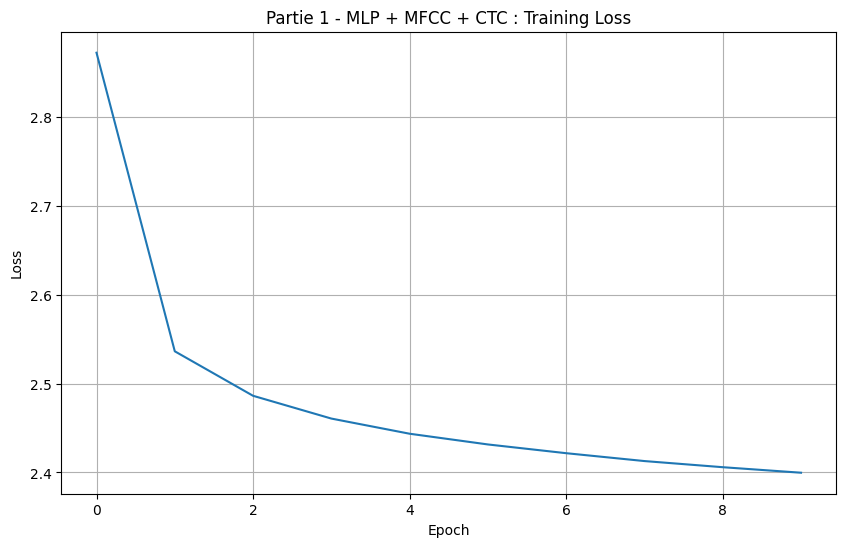

In [ ]:
if 'train_losses_mlp' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_mlp)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Partie 1 - MLP + MFCC + CTC : Training Loss')
    plt.grid(True)
    plt.show()


In [ ]:

librispeech_dir = 'data/LibriSpeech'
subset = 'train-clean-100'

print(" Chargement LibriSpeech pour Partie 2 (CNN + MLP + MelSpectrogram)...")
dataset = LibriSpeechDataset(librispeech_dir, None, subset=subset, n_mfcc=None)

if len(dataset.data) > 0:
    if 'encoder_mfcc' in locals():
        encoder = encoder_mfcc
        vocab_size = encoder.get_vocab_size()
        print(" Réutilisation de l'encoder de la Partie 1")
    else:
        texts = [transcription for _, transcription in dataset.data]
        encoder = CharEncoder()
        encoder.build_vocab(texts)
        vocab_size = encoder.get_vocab_size()
        print(" Nouvel encoder créé")
    
    dataset.encoder = encoder
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    
    model = CNNMLPASR(
        input_size=N_MELS,
        vocab_size=vocab_size,
        conv_channels=[64, 128, 256],
        kernel_sizes=[3, 3, 3],
    ).to(device)
    
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print(f"Modèle CNN+MLP créé: {sum(p.numel() for p in model.parameters())} paramètres")
    print(f" Vocabulaire: {vocab_size} caractères")
    print(f"Dataset: {len(dataset)} échantillons")
else:
    print(" Aucun échantillon trouvé dans LibriSpeech!")
    print(f"   Vérifiez que {librispeech_dir}/{subset} existe et contient des fichiers .flac")
    dataloader = None
    model = None


 Chargement LibriSpeech pour Partie 2 (CNN + MLP + MelSpectrogram)...
 Chargé 28539 échantillons depuis train-clean-100
 Réutilisation de l'encoder de la Partie 1
Modèle CNN+MLP créé: 278621 paramètres
 Vocabulaire: 29 caractères
Dataset: 28539 échantillons


In [34]:
if 'model' in locals() and 'dataloader' in locals() and model is not None and dataloader is not None:
    model.train()
    train_losses = []
    
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, (melspectrograms, texts, mel_lengths, text_lengths) in enumerate(dataloader):
            melspectrograms = melspectrograms.to(device)
            texts = texts.to(device)
            mel_lengths = mel_lengths.to(device)
            text_lengths = text_lengths.to(device)
            
            optimizer.zero_grad()
            
            logits = model(melspectrograms)
            log_probs = nn.functional.log_softmax(logits, dim=2)
            
            log_probs = log_probs.transpose(0, 1)
            
            loss = criterion(log_probs, texts, mel_lengths, text_lengths)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] completed, Average Loss: {avg_loss:.4f}')
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'encoder': encoder,
        'vocab_size': vocab_size,
        'config': {
            'n_mels': N_MELS,
            'hidden_size': HIDDEN_SIZE,
            'num_layers': NUM_LAYERS,
            'dropout': DROPOUT
        }
    }, 'checkpoint.pth')
    


Epoch [1/10], Batch [10/892], Loss: 3.5459
Epoch [1/10], Batch [20/892], Loss: 3.1387
Epoch [1/10], Batch [30/892], Loss: 2.9756
Epoch [1/10], Batch [40/892], Loss: 2.8890
Epoch [1/10], Batch [50/892], Loss: 2.9099
Epoch [1/10], Batch [60/892], Loss: 2.8715
Epoch [1/10], Batch [70/892], Loss: 2.8826
Epoch [1/10], Batch [80/892], Loss: 2.8872
Epoch [1/10], Batch [90/892], Loss: 2.8612
Epoch [1/10], Batch [100/892], Loss: 2.8572
Epoch [1/10], Batch [110/892], Loss: 2.8555
Epoch [1/10], Batch [120/892], Loss: 2.8753
Epoch [1/10], Batch [130/892], Loss: 2.8597
Epoch [1/10], Batch [140/892], Loss: 2.8884
Epoch [1/10], Batch [150/892], Loss: 2.8839
Epoch [1/10], Batch [160/892], Loss: 2.8677
Epoch [1/10], Batch [170/892], Loss: 2.8676
Epoch [1/10], Batch [180/892], Loss: 2.8533
Epoch [1/10], Batch [190/892], Loss: 2.8581
Epoch [1/10], Batch [200/892], Loss: 2.8784
Epoch [1/10], Batch [210/892], Loss: 2.8412
Epoch [1/10], Batch [220/892], Loss: 2.8603
Epoch [1/10], Batch [230/892], Loss: 2.88

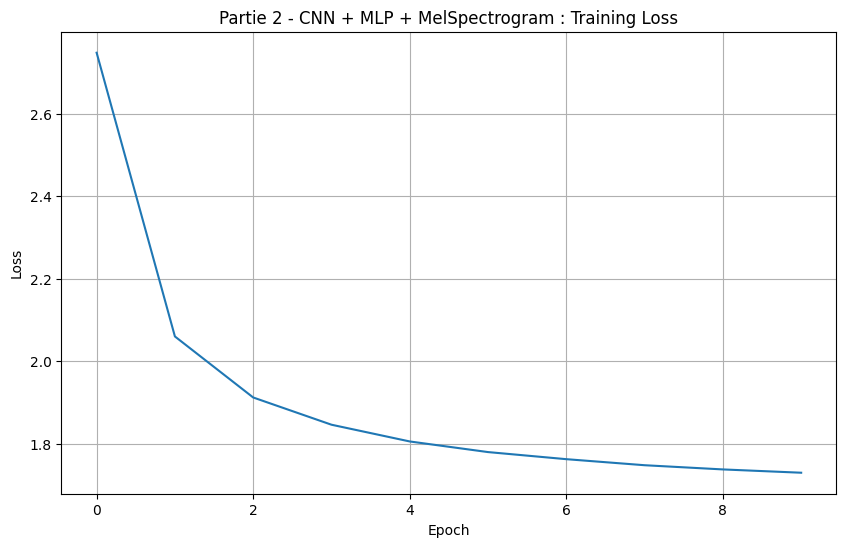

In [ ]:
if 'train_losses' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Partie 2 - CNN + MLP + MelSpectrogram : Training Loss')
    plt.grid(True)
    plt.show()

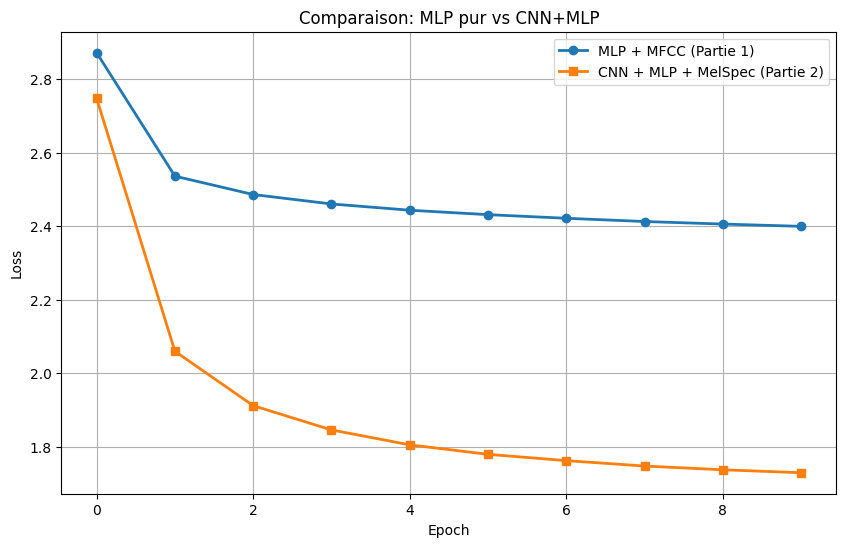

In [ ]:
if 'train_losses_mlp' in locals() and 'train_losses' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_mlp, label='MLP + MFCC (Partie 1)', linewidth=2, marker='o')
    plt.plot(train_losses, label='CNN + MLP + MelSpec (Partie 2)', linewidth=2, marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Comparaison: MLP pur vs CNN+MLP')
    plt.legend()
    plt.grid(True)
    plt.show()

Avec le CNN, il a converge plus vite et a fini avec une loss plus basse.

## Partie 3 — RNN (LSTM / GRU)


### Architecture RNN avec LSTM/GRU


In [ ]:
import time

class CNNRNNASR(nn.Module):
    def __init__(
        self,
        input_size,
        vocab_size,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        rnn_type='LSTM',
        bidirectional=False,
        conv_channels=[64, 128, 256],
        kernel_sizes=[3, 3, 3],
    ):
        super(CNNRNNASR, self).__init__()
        
        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        
        self.conv_layers = nn.ModuleList()
        in_channels = input_size

        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels, out_channels, kernel_size, padding=kernel_size // 2
                    ),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                )
            )
            in_channels = out_channels

        conv_output_size = conv_channels[-1]
        
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=conv_output_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=conv_output_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:
            raise ValueError(f"rnn_type doit être 'LSTM' ou 'GRU', reçu: {rnn_type}")
        
        rnn_output_size = hidden_size * (2 if bidirectional else 1)
        
        self.fc = nn.Linear(rnn_output_size, vocab_size)
        
    def forward(self, x):
        batch_size, seq_len, features = x.size()
        x = x.transpose(1, 2)
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        x = x.transpose(1, 2)
        rnn_out, _ = self.rnn(x)
        output = self.fc(rnn_out)
        
        return output


### Fonction d'entraînement réutilisable avec métriques


In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=NUM_EPOCHS, model_name="Model", max_grad_norm=1.0):
    model.train()
    train_losses = []
    batch_losses = []
    sequence_lengths = []
    epoch_times = []
    
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        num_batches = 0
        skipped_batches = 0
        
        for batch_idx, (melspectrograms, texts, mel_lengths, text_lengths) in enumerate(dataloader):
            melspectrograms = melspectrograms.to(device)
            texts = texts.to(device)
            mel_lengths = mel_lengths.to(device)
            text_lengths = text_lengths.to(device)
            
            if (mel_lengths <= 0).any() or (text_lengths <= 0).any():
                skipped_batches += 1
                continue
            
            if (mel_lengths < text_lengths).any():
                skipped_batches += 1
                continue
            
            sequence_lengths.extend(mel_lengths.cpu().numpy().tolist())
            
            optimizer.zero_grad()
            
            try:
                logits = model(melspectrograms)
                log_probs = nn.functional.log_softmax(logits, dim=2)
                log_probs = log_probs.transpose(0, 1)
                
                loss = criterion(log_probs, texts, mel_lengths, text_lengths)
                
                if not torch.isfinite(loss) or loss.item() > 1000:
                    skipped_batches += 1
                    if (batch_idx + 1) % 10 == 0:
                        print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f} (SKIPPED - invalid loss)')
                    continue
                
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                
                optimizer.step()
                
                loss_value = loss.item()
                epoch_loss += loss_value
                num_batches += 1
                batch_losses.append(loss_value)
                
                if (batch_idx + 1) % 10 == 0:
                    print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss_value:.4f}')
            
            except RuntimeError as e:
                if "CTC" in str(e) or "length" in str(e).lower():
                    skipped_batches += 1
                    if (batch_idx + 1) % 10 == 0:
                        print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], SKIPPED - CTC error: {str(e)[:50]}')
                    continue
                else:
                    raise
        
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        avg_loss = epoch_loss / num_batches if num_batches > 0 else float('inf')
        train_losses.append(avg_loss)
        print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s, Skipped batches: {skipped_batches}')
    
    total_time = time.time() - total_start_time
    
    metrics = {
        'train_losses': train_losses,
        'batch_losses': batch_losses,
        'sequence_lengths': sequence_lengths,
        'epoch_times': epoch_times,
        'total_time': total_time,
        'final_loss': train_losses[-1] if train_losses else None,
    }
    
    return metrics


### Calcul des métriques d'analyse


In [ ]:
def compute_metrics(metrics_dict, model_name="Model"):
    train_losses = metrics_dict['train_losses']
    batch_losses = metrics_dict['batch_losses']
    epoch_times = metrics_dict['epoch_times']
    sequence_lengths = metrics_dict['sequence_lengths']
    
    avg_epoch_time = np.mean(epoch_times)
    total_time = metrics_dict['total_time']
    final_loss = metrics_dict['final_loss']
    
    num_batches_per_epoch = len(batch_losses) // len(train_losses) if train_losses else len(batch_losses)
    batch_losses_array = np.array(batch_losses)
    
    loss_variance = np.var(batch_losses_array)
    loss_std = np.std(batch_losses_array)
    
    epoch_variances = []
    for i in range(len(train_losses)):
        start_idx = i * num_batches_per_epoch
        end_idx = start_idx + num_batches_per_epoch
        if end_idx <= len(batch_losses):
            epoch_variances.append(np.var(batch_losses_array[start_idx:end_idx]))
    
    avg_epoch_variance = np.mean(epoch_variances) if epoch_variances else 0
    
    if sequence_lengths:
        max_seq_len = max(sequence_lengths)
        min_seq_len = min(sequence_lengths)
        avg_seq_len = np.mean(sequence_lengths)
        median_seq_len = np.median(sequence_lengths)
    else:
        max_seq_len = min_seq_len = avg_seq_len = median_seq_len = 0
    
    results = {
        'model_name': model_name,
        'vitesse': {
            'temps_total': total_time,
            'temps_moyen_par_epoch': avg_epoch_time,
            'temps_par_epoch': epoch_times,
        },
        'stabilite_ctc': {
            'variance_globale': loss_variance,
            'ecart_type_global': loss_std,
            'variance_moyenne_par_epoch': avg_epoch_variance,
            'variances_par_epoch': epoch_variances,
        },
        'capacite_temporelle': {
            'longueur_max': max_seq_len,
            'longueur_min': min_seq_len,
            'longueur_moyenne': avg_seq_len,
            'longueur_mediane': median_seq_len,
            'longueurs': sequence_lengths,
        },
        'performance': {
            'perte_finale': final_loss,
            'pertes_par_epoch': train_losses,
        }
    }
    
    return results


### Entraînement et comparaison des architectures


In [46]:
all_results = {}

if 'dataloader' in locals() and dataloader is not None:
    print("Dataset disponible, début de l'entraînement des modèles RNN...")
else:
    print("Chargement du dataset...")
    transcriptions_file = 'data/ss-corpus-fr.tsv'
    audio_dir = 'data/audios'
    
    if os.path.exists(transcriptions_file):
        with open(transcriptions_file, 'r', encoding='utf-8') as f:
            next(f)
            texts = [line.split('\t')[6].strip() for line in f if line.strip() and len(line.split('\t')) >= 7 and line.split('\t')[6].strip()]
        
        if 'encoder' not in locals():
            encoder = CharEncoder()
            encoder.build_vocab(texts)
            vocab_size = encoder.get_vocab_size()
        else:
            vocab_size = encoder.get_vocab_size()
        
        dataset = ASRDataset(transcriptions_file, audio_dir, encoder)
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


Dataset disponible, début de l'entraînement des modèles RNN...


#### 1. Entraînement LSTM


In [47]:
if dataloader is not None:
    model_lstm = CNNRNNASR(
        input_size=N_MELS,
        vocab_size=vocab_size,
        rnn_type='LSTM',
        bidirectional=False,
        conv_channels=[64, 128, 256],
        kernel_sizes=[3, 3, 3],
    ).to(device)
    
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
    
    metrics_lstm = train_model(model_lstm, dataloader, criterion, optimizer_lstm, 
                                num_epochs=NUM_EPOCHS, model_name="LSTM")
    
    results_lstm = compute_metrics(metrics_lstm, model_name="LSTM")
    all_results['LSTM'] = results_lstm


[LSTM] Epoch [1/10], Batch [10/892], Loss: 3.7253
[LSTM] Epoch [1/10], Batch [20/892], Loss: 3.0663
[LSTM] Epoch [1/10], Batch [30/892], Loss: 2.9604
[LSTM] Epoch [1/10], Batch [40/892], Loss: 2.9194
[LSTM] Epoch [1/10], Batch [50/892], Loss: 2.8861
[LSTM] Epoch [1/10], Batch [60/892], Loss: 2.8973
[LSTM] Epoch [1/10], Batch [70/892], Loss: 2.8894
[LSTM] Epoch [1/10], Batch [80/892], Loss: 2.8732
[LSTM] Epoch [1/10], Batch [90/892], Loss: 2.8901
[LSTM] Epoch [1/10], Batch [100/892], Loss: 2.8769
[LSTM] Epoch [1/10], Batch [110/892], Loss: 2.8769
[LSTM] Epoch [1/10], Batch [120/892], Loss: 2.8679
[LSTM] Epoch [1/10], Batch [130/892], Loss: 2.8782
[LSTM] Epoch [1/10], Batch [140/892], Loss: 2.8724
[LSTM] Epoch [1/10], Batch [150/892], Loss: 2.8847
[LSTM] Epoch [1/10], Batch [160/892], Loss: 2.8564
[LSTM] Epoch [1/10], Batch [170/892], Loss: 2.8797
[LSTM] Epoch [1/10], Batch [180/892], Loss: 2.8553
[LSTM] Epoch [1/10], Batch [190/892], Loss: 2.8879
[LSTM] Epoch [1/10], Batch [200/892], Lo

#### 2. Entraînement GRU


In [51]:
if dataloader is not None:
    model_gru = CNNRNNASR(
        input_size=N_MELS,
        vocab_size=vocab_size,
        rnn_type='GRU',
        bidirectional=False,
        conv_channels=[64, 128, 256],
        kernel_sizes=[3, 3, 3],
    ).to(device)
    
    optimizer_gru = optim.Adam(model_gru.parameters(), lr=LEARNING_RATE)
    
    metrics_gru = train_model(model_gru, dataloader, criterion, optimizer_gru, 
                              num_epochs=NUM_EPOCHS, model_name="GRU")
    
    results_gru = compute_metrics(metrics_gru, model_name="GRU")
    all_results['GRU'] = results_gru

[GRU] Epoch [1/10], Batch [10/892], Loss: 3.0414
[GRU] Epoch [1/10], Batch [20/892], Loss: 2.8967
[GRU] Epoch [1/10], Batch [30/892], Loss: 2.8796
[GRU] Epoch [1/10], Batch [40/892], Loss: 2.8790
[GRU] Epoch [1/10], Batch [50/892], Loss: 2.8664
[GRU] Epoch [1/10], Batch [60/892], Loss: 2.8763
[GRU] Epoch [1/10], Batch [70/892], Loss: 2.8664
[GRU] Epoch [1/10], Batch [80/892], Loss: 2.8819
[GRU] Epoch [1/10], Batch [90/892], Loss: 2.8532
[GRU] Epoch [1/10], Batch [100/892], Loss: 2.8340
[GRU] Epoch [1/10], Batch [110/892], Loss: 2.7861
[GRU] Epoch [1/10], Batch [120/892], Loss: 2.7305
[GRU] Epoch [1/10], Batch [130/892], Loss: 2.6966
[GRU] Epoch [1/10], Batch [140/892], Loss: 2.6431
[GRU] Epoch [1/10], Batch [150/892], Loss: 2.5765
[GRU] Epoch [1/10], Batch [160/892], Loss: 2.5398
[GRU] Epoch [1/10], Batch [170/892], Loss: 2.4276
[GRU] Epoch [1/10], Batch [180/892], Loss: 2.3891
[GRU] Epoch [1/10], Batch [190/892], Loss: 2.2862
[GRU] Epoch [1/10], Batch [200/892], Loss: nan (SKIPPED - i

#### 3. Comparaison

In [53]:
headers = ['Modèle', 'Perte finale', 'Temps total (s)', 
           'Variance CTC', 'Écart-type CTC', 'Long. moy. séq.']
print(f"{headers[0]:<15} {headers[1]:<15} {headers[2]:<18} "
      f"{headers[3]:<15} {headers[4]:<18} {headers[5]:<18}")

for model_name in ['LSTM', 'GRU']:
    if model_name in all_results:
        results = all_results[model_name]
        
        perte = results['performance']['perte_finale']
        perte_str = f"{perte:.4f}" if perte is not None else "N/A"
        
        temps_total = results['vitesse']['temps_total']
        temps_total_str = f"{temps_total:.2f}" if temps_total is not None else "N/A"
        
        variance = results['stabilite_ctc']['variance_globale']
        variance_str = f"{variance:.4f}" if variance is not None else "N/A"
        
        std = results['stabilite_ctc']['ecart_type_global']
        std_str = f"{std:.4f}" if std is not None else "N/A"
        
        long_moy = results['capacite_temporelle']['longueur_moyenne']
        long_moy_str = f"{long_moy:.1f}" if long_moy is not None else "N/A"
        
        print(f"{model_name:<15} {perte_str:<15} {temps_total_str:<18} "
              f"{variance_str:<15} {std_str:<18} {long_moy_str:<18}")



Modèle          Perte finale    Temps total (s)    Variance CTC    Écart-type CTC     Long. moy. séq.   
LSTM            0.8715          2805.27            0.4317          0.6570             1269.6            
GRU             inf             1924.85            2.1226          1.4569             1269.6            


On remarque des temps d'entrainements beaucoup plus long qu'avec un simple MLP pour une loss similaire\
Pour la capacite temporelle, c'est quasi similaire entre GRU et LSTM\
Au niveau de la stabilite CTC, GRU semble etre plus stable ce qui veut dire qu'il a un entrainement plus previsible

## Partie 4 — Transformer ASR


### Architecture Transformer avec Self-Attention


In [55]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [56]:
class TransformerASR(nn.Module):
    def __init__(
        self,
        input_size,
        vocab_size,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=2048,
        dropout=0.1,
        max_len=5000,
    ):
        super(TransformerASR, self).__init__()
        
        self.d_model = d_model
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len, dropout=dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='relu'
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        self.output_projection = nn.Linear(d_model, vocab_size)
        
    def forward(self, x, mel_lengths=None):
        batch_size, seq_len, _ = x.size()
        
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        
        src_key_padding_mask = None
        if mel_lengths is not None:
            max_len = x.size(1)
            src_key_padding_mask = torch.arange(max_len, device=x.device).expand(
                batch_size, max_len
            ) >= mel_lengths.unsqueeze(1)
        
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = self.output_projection(x)
        
        return x


### Fonction d'entraînement


In [ ]:
def train_model_with_masks(model, dataloader, criterion, optimizer, num_epochs=NUM_EPOCHS, model_name="Model", max_grad_norm=1.0):
    model.train()
    train_losses = []
    batch_losses = []
    sequence_lengths = []
    epoch_times = []
    
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        num_batches = 0
        skipped_batches = 0
        
        for batch_idx, (melspectrograms, texts, mel_lengths, text_lengths) in enumerate(dataloader):
            melspectrograms = melspectrograms.to(device)
            texts = texts.to(device)
            mel_lengths = mel_lengths.to(device)
            text_lengths = text_lengths.to(device)
            
            if (mel_lengths <= 0).any() or (text_lengths <= 0).any():
                skipped_batches += 1
                continue
            
            if (mel_lengths < text_lengths).any():
                skipped_batches += 1
                continue
            
            sequence_lengths.extend(mel_lengths.cpu().numpy().tolist())
            
            optimizer.zero_grad()
            
            try:
                import inspect
                sig = inspect.signature(model.forward)
                if 'mel_lengths' in sig.parameters:
                    logits = model(melspectrograms, mel_lengths=mel_lengths)
                else:
                    logits = model(melspectrograms)
            except:
                try:
                    logits = model(melspectrograms, mel_lengths=mel_lengths)
                except TypeError:
                    logits = model(melspectrograms)
            
            log_probs = nn.functional.log_softmax(logits, dim=2)
            log_probs = log_probs.transpose(0, 1)
            
            loss = criterion(log_probs, texts, mel_lengths, text_lengths)
            
            if not torch.isfinite(loss) or loss.item() > 1000:
                skipped_batches += 1
                if (batch_idx + 1) % 10 == 0:
                    print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f} (SKIPPED - invalid loss)')
                continue
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            
            loss_value = loss.item()
            epoch_loss += loss_value
            num_batches += 1
            batch_losses.append(loss_value)
            
            if (batch_idx + 1) % 10 == 0:
                print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss_value:.4f}')
        
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)
        avg_loss = epoch_loss / num_batches if num_batches > 0 else float('inf')
        train_losses.append(avg_loss)
        print(f'[{model_name}] Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s, Skipped batches: {skipped_batches}')
    
    total_time = time.time() - total_start_time
    
    metrics = {
        'train_losses': train_losses,
        'batch_losses': batch_losses,
        'sequence_lengths': sequence_lengths,
        'epoch_times': epoch_times,
        'total_time': total_time,
        'final_loss': train_losses[-1] if train_losses else None,
    }
    
    return metrics


#### 3. Entraînement Transformer


In [59]:
if dataloader is not None:
    model_transformer = TransformerASR(
        input_size=N_MELS,
        vocab_size=vocab_size,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=2048,
        dropout=DROPOUT,
    ).to(device)
    
    criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=LEARNING_RATE)
    
    metrics_transformer = train_model_with_masks(
        model_transformer, 
        dataloader, 
        criterion, 
        optimizer_transformer,
        num_epochs=1, 
        model_name="Transformer"
    )
    
    results_transformer = compute_metrics(metrics_transformer, model_name="Transformer")
    all_results['Transformer'] = results_transformer


[Transformer] Epoch [1/1], Batch [10/892], Loss: 4.9424
[Transformer] Epoch [1/1], Batch [20/892], Loss: 4.1104
[Transformer] Epoch [1/1], Batch [30/892], Loss: 4.0325
[Transformer] Epoch [1/1], Batch [40/892], Loss: 4.0148
[Transformer] Epoch [1/1], Batch [50/892], Loss: 3.9338
[Transformer] Epoch [1/1], Batch [60/892], Loss: 3.8390
[Transformer] Epoch [1/1], Batch [70/892], Loss: 3.7779
[Transformer] Epoch [1/1], Batch [80/892], Loss: 3.8060
[Transformer] Epoch [1/1], Batch [90/892], Loss: 4.6524


KeyboardInterrupt: 

#### 4. Comparaison


In [60]:
headers = ['Modèle', 'Perte finale', 'Temps total (s)', 
           'Variance CTC', 'Écart-type CTC', 'Long. moy. séq.']
print(f"{headers[0]:<15} {headers[1]:<15} {headers[2]:<18} "
      f"{headers[3]:<15} {headers[4]:<18} {headers[5]:<18}")

for model_name in ['LSTM', 'GRU', 'Transformer']:
    if model_name in all_results:
        results = all_results[model_name]
        
        perte = results['performance']['perte_finale']
        perte_str = f"{perte:.4f}" if perte is not None else "N/A"
        
        temps_total = results['vitesse']['temps_total']
        temps_total_str = f"{temps_total:.2f}" if temps_total is not None else "N/A"
        
        variance = results['stabilite_ctc']['variance_globale']
        variance_str = f"{variance:.4f}" if variance is not None else "N/A"
        
        std = results['stabilite_ctc']['ecart_type_global']
        std_str = f"{std:.4f}" if std is not None else "N/A"
        
        long_moy = results['capacite_temporelle']['longueur_moyenne']
        long_moy_str = f"{long_moy:.1f}" if long_moy is not None else "N/A"
        
        print(f"{model_name:<15} {perte_str:<15} {temps_total_str:<18} "
              f"{variance_str:<15} {std_str:<18} {long_moy_str:<18}")


Modèle          Perte finale    Temps total (s)    Variance CTC    Écart-type CTC     Long. moy. séq.   
LSTM            0.8715          2805.27            0.4317          0.6570             1269.6            
GRU             inf             1924.85            2.1226          1.4569             1269.6            


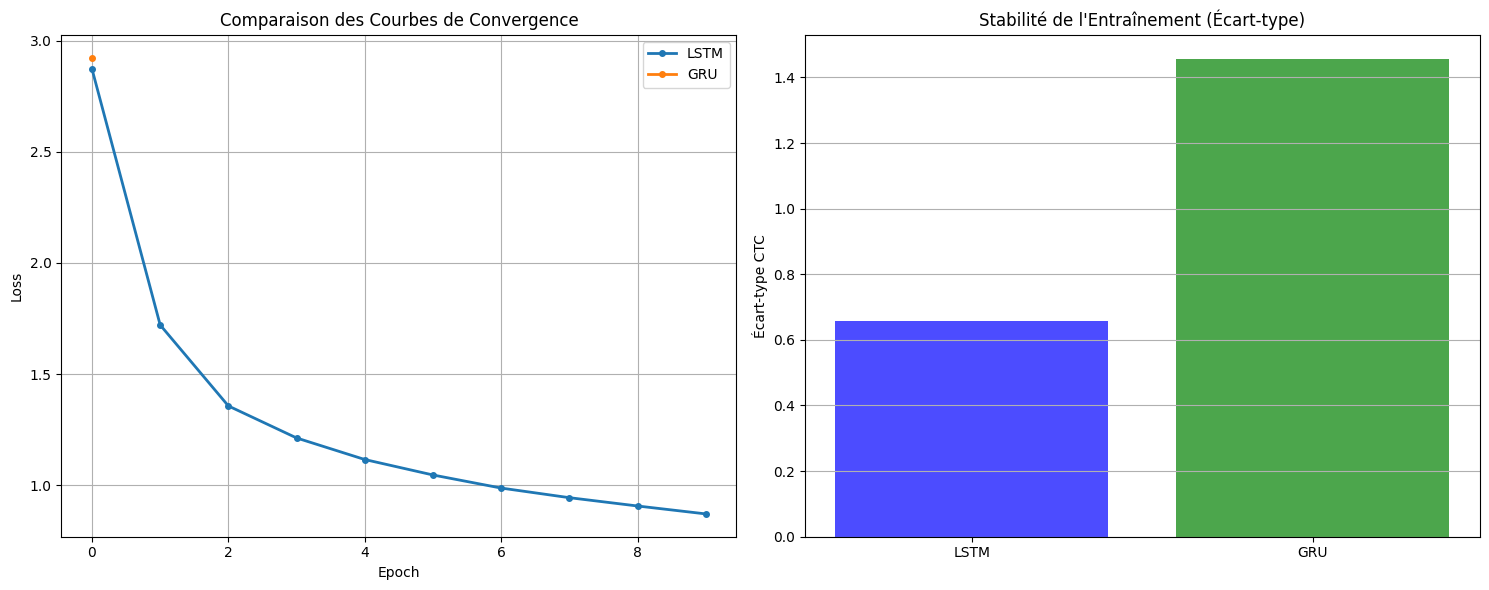

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for model_name in ['LSTM', 'GRU', 'Transformer']:
    if model_name in all_results:
        losses = all_results[model_name]['performance']['pertes_par_epoch']
        axes[0].plot(losses, label=model_name, linewidth=2, marker='o', markersize=4)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Comparaison des Courbes de Convergence')
axes[0].legend()
axes[0].grid(True)

model_names = []
std_values = []
for model_name in ['LSTM', 'GRU', 'Transformer']:
    if model_name in all_results:
        model_names.append(model_name)
        std_values.append(all_results[model_name]['stabilite_ctc']['ecart_type_global'])

axes[1].bar(model_names, std_values, alpha=0.7, color=['blue', 'green', 'red'])
axes[1].set_ylabel('Écart-type CTC')
axes[1].set_title('Stabilité de l\'Entraînement (Écart-type)')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()
